In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../../')
print(f"New working dir {os.getcwd()}")

In [4]:
from pathlib import Path
plots_dir = Path('./conformal_plots/')
os.makedirs(plots_dir, exist_ok=True)

In [5]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
results_dir = Path('./conformal_results_u/')
#results_dir = Path('./conformal_results/')

In [7]:
from conformal.real_datasets.process_raw import datasets

In [8]:
n_targets = {"rf1": 8, "rf2": 8, "scm1d": 16, "scm20d": 16, "sgemm": 4, "bio": 2, "blog": 2}
df_n_targets = pd.DataFrame({"dataset_name": n_targets.keys(), "n_targets": n_targets.values()})
df_n_targets

,dataset_name,n_targets
0,rf1,8
1,rf2,8
2,scm1d,16
3,scm20d,16
4,sgemm,4
5,bio,2
6,blog,2


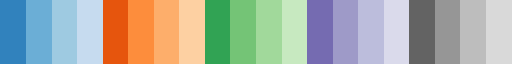

In [9]:
t20c = matplotlib.colormaps["tab20c"]
t20c

In [10]:
palette = {
    "OT-CP-Global": t20c(0),
    "OT-CP-Local": t20c(1),
    "Ell-Local": t20c(2),
    "PB": t20c(4),
    "RPB": t20c(5),
    "HPD": t20c(6),
    "Quantile": t20c(7),
    "PB (CPFlow)": t20c(8),
    "RPB (CPFlow)": t20c(9),
    "HPD (CPFlow)": t20c(10),
    "Quantile (CPFlow)": t20c(11),
    "PB (Y)": t20c(12),
    "RPB (Y)": t20c(13),
    "HPD (Y)": t20c(14),
    "Quantile (Y)": t20c(15),
}

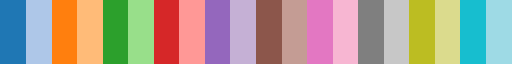

In [11]:
colormap = matplotlib.colormaps["tab20"]
colormap

In [12]:
selected_palette = {
    "OT-CP-Global": colormap(0),
    "OT-CP-Local": colormap(1),
    "PB": colormap(2),
    "RPB": colormap(3),
    "PB (RF)": colormap(4),
    "RPB (RF)": colormap(5),
    
    "PB (Y, RF)": colormap(6),
    "RPB (Y, RF)": colormap(7),

    "PB (Y)": colormap(8),
    "RPB (Y)": colormap(9),
    
    "Ell-Local": colormap(12),
}

In [13]:
# Where to load each method/metric from?


In [14]:
from typing import Literal

def load_methods_from(method_names: List[str], path: str | Path, seeds=range(10), extention: Literal["feather", "csv"] = "feather") -> pd.DataFrame:
    dataframes = []
    #seeds = range(10)
    for seed in seeds:
        for dataset_name in datasets:
            fn = Path(path) / dataset_name / str(seed) / f"metrics_all.{extention}"
            if fn.is_file():
                if extention == "feather":
                    dataframes.append(pd.read_feather(fn))
                else:
                    dataframes.append(pd.read_csv(fn))
            else:
                print(f"Error: dataset {dataset_name}, seed {seed} not found.")
    df = pd.concat(dataframes).merge(df_n_targets, on="dataset_name")
    if "volume" in df.columns:
        df["log_vol_d"] = np.log(df["volume"]) / df["n_targets"]
    if len(method_names) > 0:
        df = df[df["method_name"].isin(method_names)]
    return df


In [15]:
df0 = load_methods_from(method_names=[], path="./conformal_results_u/")

Error: dataset scm1d, seed 2 not found.
Error: dataset sgemm, seed 2 not found.
Error: dataset sgemm, seed 3 not found.
Error: dataset scm1d, seed 6 not found.
Error: dataset sgemm, seed 7 not found.
Error: dataset bio, seed 7 not found.
Error: dataset blog, seed 7 not found.
Error: dataset sgemm, seed 9 not found.


/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
#df.head(20)
df1 = load_methods_from(method_names=[], path="./conformal_results_u/")
df2 = load_methods_from(method_names=[], path="./conformal_results_250923/", extention="csv")

Error: dataset scm1d, seed 2 not found.
Error: dataset sgemm, seed 2 not found.
Error: dataset sgemm, seed 3 not found.
Error: dataset scm1d, seed 6 not found.
Error: dataset sgemm, seed 7 not found.
Error: dataset bio, seed 7 not found.
Error: dataset blog, seed 7 not found.
Error: dataset sgemm, seed 9 not found.
Error: dataset rf1, seed 0 not found.
Error: dataset scm1d, seed 0 not found.
Error: dataset sgemm, seed 0 not found.
Error: dataset rf1, seed 1 not found.
Error: dataset scm1d, seed 1 not found.
Error: dataset sgemm, seed 1 not found.
Error: dataset rf1, seed 2 not found.
Error: dataset scm1d, seed 2 not found.
Error: dataset rf1, seed 3 not found.
Error: dataset scm1d, seed 3 not found.
Error: dataset rf1, seed 4 not found.
Error: dataset scm1d, seed 4 not found.
Error: dataset rf1, seed 5 not found.
Error: dataset scm1d, seed 5 not found.
Error: dataset rf1, seed 6 not found.
Error: dataset scm1d, seed 6 not found.
Error: dataset rf1, seed 7 not found.
Error: dataset scm1

/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
df1["method_name"].unique(), df2.method_name.unique()

(array(['OT-CP-Global', 'OT-CP-Local', 'Ell-Local', 'PB', 'RPB', 'HPD',
        'Quantile', 'PB (Y)', 'RPB (Y)', 'HPD (Y)', 'Quantile (Y)',
        'PB (CPFlow)', 'RPB (CPFlow)', 'HPD (CPFlow)', 'Quantile (CPFlow)'],
       dtype=object),
 array(['PB (RF)', 'RPB (RF)', 'HPD (RF)', 'Quantile (RF)', 'PB (Y, RF)',
        'RPB (Y, RF)', 'HPD (Y, RF)', 'Quantile (Y, RF)'], dtype=object))

In [18]:
df1

,dataset_name,seed,method_name,method_name_mathtext,score_name,conformalizer,base_model_name,alpha,marginal_coverage,worst_slab_coverage,worst_slab_coverage_se,volume,n_targets,log_vol_d
0,rf1,0,OT-CP-Global,$\mathrm{OT}$-$\mathrm{CP}$,Signed Error,OTCPGlobalPredictor,RandomForest,0.1,0.8945,0.887931,0.000000e+00,6.714239e+04,8,1.389321
1,rf1,0,OT-CP-Local,$\mathrm{OT}$-$\mathrm{CP}$+,Signed Error,OTCPLocalPredictor,RandomForest,0.1,0.9110,0.878261,0.000000e+00,1.059603e-04,8,-1.144056
2,rf1,0,Ell-Local,$\mathrm{ELL}$-$\mathrm{local}$+,Signed Error,EllipsoidalLocal,RandomForest,0.1,0.8910,0.781065,3.700743e-17,2.223003e-11,8,-3.066197
3,rf1,0,PB,$\mathcal{C}^{\mathrm{pb}}$,MK Rank,SplitConformalPredictor,CVQRegressor,0.1,0.9105,0.805882,0.000000e+00,2.297792e-01,8,-0.183830
4,rf1,0,RPB,$\mathcal{C}^{\mathrm{rpb}}$,MK Quantile,OTCPGlobalPredictor,CVQRegressor,0.1,0.8985,0.784810,0.000000e+00,1.382279e+05,8,1.479582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,blog,9,Quantile (Y),$Q_{Y|X} \: Y$,MK Rank,QuantileEstimatePredictor,CVQRegressorY,0.3,0.7095,0.658385,0.000000e+00,2.475448e-01,2,-0.698082
2786,blog,9,PB (CPFlow),$\mathcal{C}^{\mathrm{pb}}$ (CPFlow),MK Rank,SplitConformalPredictor,CPFlowRegressor,0.3,0.7175,0.729560,0.000000e+00,4.550380e-01,2,-0.393687
2787,blog,9,RPB (CPFlow),$\mathcal{C}^{\mathrm{rpb}}$ (CPFlow),MK Quantile,OTCPGlobalPredictor,CPFlowRegressor,0.3,0.7170,0.670213,0.000000e+00,7.041863e-01,2,-0.175356
2788,blog,9,HPD (CPFlow),$\mathcal{C}^{\mathrm{HPD}}$ (CPFlow),Log Density,SplitConformalPredictor,CPFlowRegressor,0.3,0.7240,0.523179,0.000000e+00,1.814317e-02,2,-2.004731


In [19]:
df2

,dataset_name,seed,method_name,method_name_mathtext,score_name,conformalizer,base_model_name,alpha,marginal_coverage,worst_slab_coverage,worst_slab_coverage_se,volume,n_targets,log_vol_d
0,rf2,0,PB (RF),$\mathcal{C}^{\mathrm{pb}} \: RF$,MK Rank,SplitConformalPredictor,CVQRegressorRF,0.1,0.9120,0.665154,0.016013,14.897353,8,0.337648
1,rf2,0,RPB (RF),$\mathcal{C}^{\mathrm{rpb}} \: RF$,MK Quantile,OTCPGlobalPredictor,CVQRegressorRF,0.1,0.9030,0.711980,0.011642,92967.430693,8,1.430001
2,rf2,0,HPD (RF),$\mathcal{C}^{\mathrm{HPD}} \: RF$,Log Density,SplitConformalPredictor,CVQRegressorRF,0.1,0.9100,0.656487,0.014431,2.585016,8,0.118716
3,rf2,0,Quantile (RF),$Q_{Y|X} \: RF$,MK Rank,QuantileEstimatePredictor,CVQRegressorRF,0.1,0.7425,0.361615,0.017302,0.191483,8,-0.206620
4,rf2,0,"PB (Y, RF)",$\mathcal{C}^{\mathrm{pb}} \: Y \: RF$,MK Rank,SplitConformalPredictor,CVQRegressorYRF,0.1,0.9010,0.614126,0.013446,476.581266,8,0.770830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,blog,9,Quantile (RF),$Q_{Y|X} \: RF$,MK Rank,QuantileEstimatePredictor,CVQRegressorRF,0.3,0.7040,0.689724,0.006339,0.361641,2,-0.508551
1068,blog,9,"PB (Y, RF)",$\mathcal{C}^{\mathrm{pb}} \: Y \: RF$,MK Rank,SplitConformalPredictor,CVQRegressorYRF,0.3,0.7255,0.645608,0.006866,0.400720,2,-0.457246
1069,blog,9,"RPB (Y, RF)",$\mathcal{C}^{\mathrm{rpb}} \: Y \: RF$,MK Quantile,OTCPGlobalPredictor,CVQRegressorYRF,0.3,0.7120,0.673763,0.013939,0.423700,2,-0.429365
1070,blog,9,"HPD (Y, RF)",$\mathcal{C}^{\mathrm{HPD}} \: Y \: RF$,Log Density,SplitConformalPredictor,CVQRegressorYRF,0.3,0.7140,0.345106,0.015688,0.132410,2,-1.010925


In [20]:
df = pd.concat([df1, df2], ignore_index=True)

In [21]:
#palette = blended_palette(df["base_model_name"], df["conformalizer"], paletteA="Set1", paletteB="Set2")

In [22]:
#pd.DataFrame.from_dict(palette, orient="index")

In [23]:
df.shape, df[['dataset_name', 'alpha', 'method_name', 'seed']].drop_duplicates().shape

((3862, 14), (3862, 4))

In [24]:
df["method_name"].unique()

array(['OT-CP-Global', 'OT-CP-Local', 'Ell-Local', 'PB', 'RPB', 'HPD',
       'Quantile', 'PB (Y)', 'RPB (Y)', 'HPD (Y)', 'Quantile (Y)',
       'PB (CPFlow)', 'RPB (CPFlow)', 'HPD (CPFlow)', 'Quantile (CPFlow)',
       'PB (RF)', 'RPB (RF)', 'HPD (RF)', 'Quantile (RF)', 'PB (Y, RF)',
       'RPB (Y, RF)', 'HPD (Y, RF)', 'Quantile (Y, RF)'], dtype=object)

In [25]:
(df0[df0['method_name'].str.contains("OT-CP")]["volume"] == 0).sum()

np.int64(10)

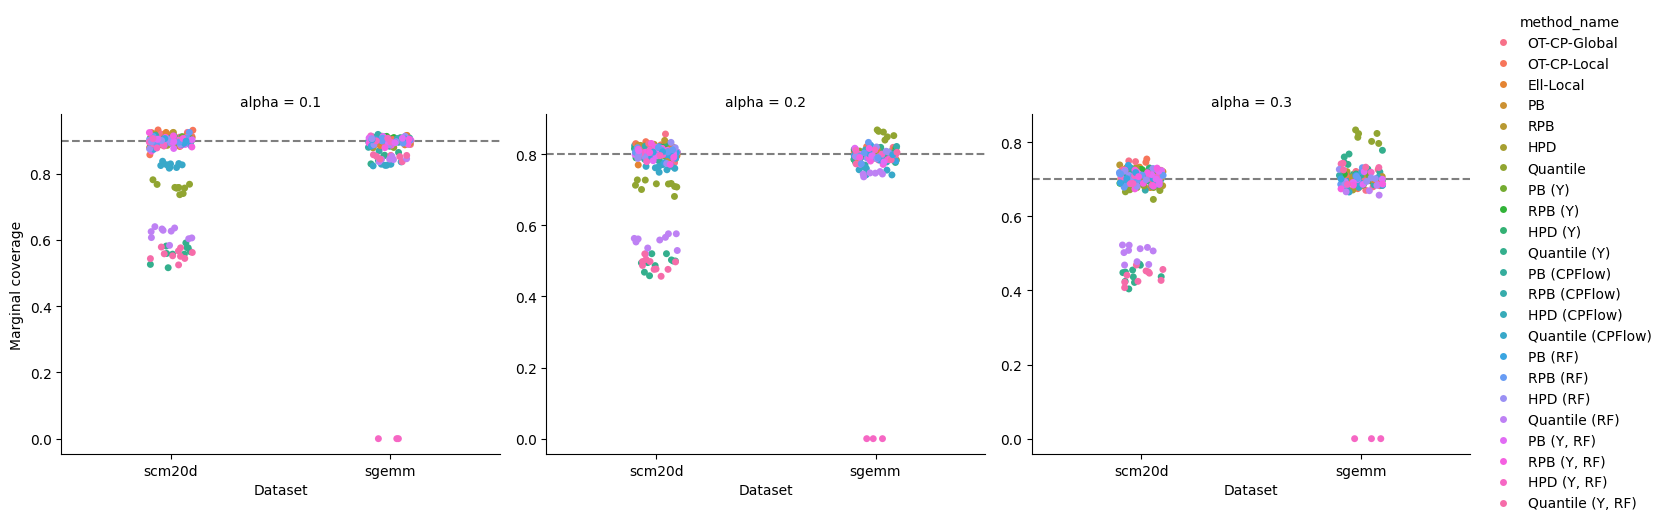

In [26]:
g_cov = sns.catplot(
    data=df[df["dataset_name"].isin(["sgemm", "scm20d"])], x="dataset_name", y="marginal_coverage", col="alpha", hue="method_name", sharey=False,
)
g_cov.set_axis_labels("Dataset", "Marginal coverage")
for alpha, ax in g_cov.axes_dict.items():
    ax.axhline(1 - alpha, ls="--", c="k", alpha=0.5)
#for ax in g_cov.axes.flatten():
#    ax.tick_params(labelbottom=True)

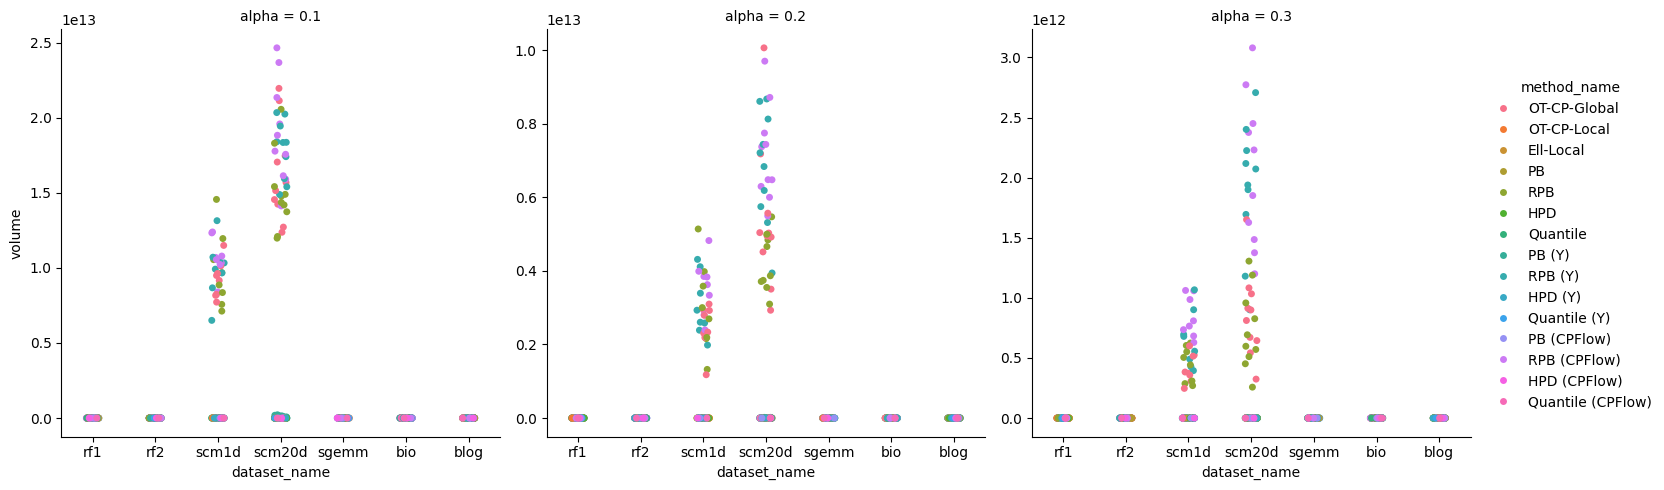

In [27]:
g_cov = sns.catplot(
    data=df0, x="dataset_name", y="volume", col="alpha", hue="method_name", sharey=False,
)

In [28]:
#g_cov.axes_dict

In [29]:
#df

In [30]:
metrics_columns = ["marginal_coverage", "worst_slab_coverage", "volume", "log_vol_d"]
id_vars = list(df.columns.difference(metrics_columns))
df_melted = pd.melt(df, id_vars=id_vars, value_vars=metrics_columns, var_name="metric", value_name="value")

In [31]:
len(df_melted)

15448

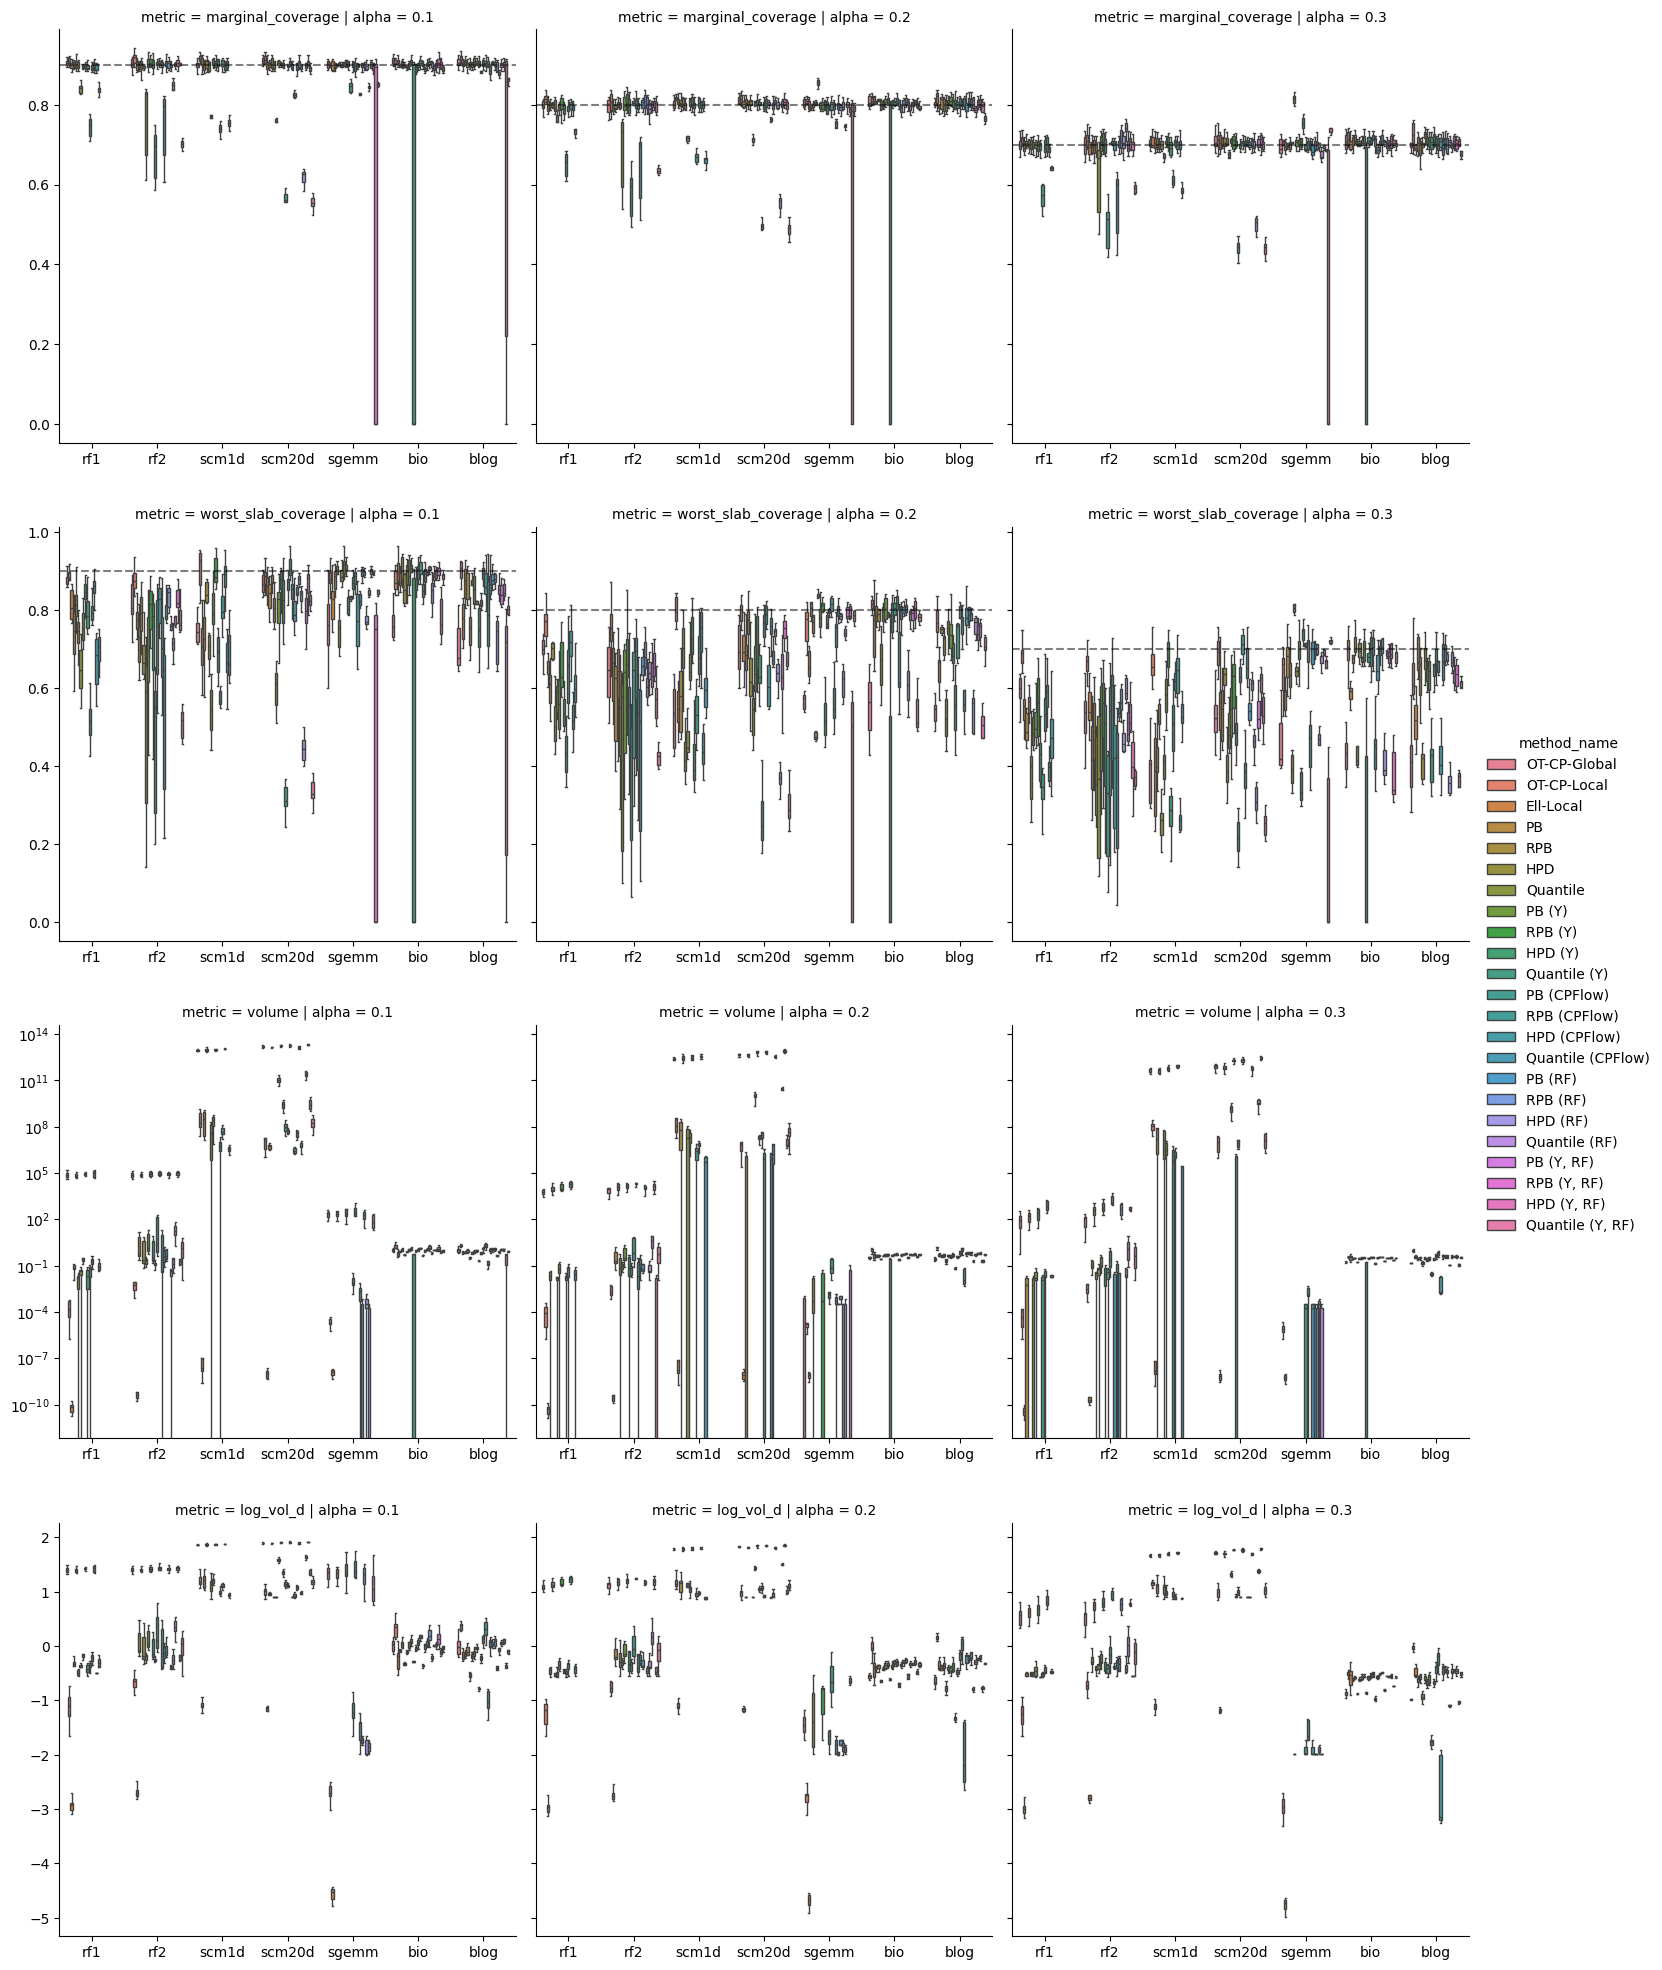

In [32]:
g_all = sns.catplot(
    data=df_melted,#.query("dataset_name == 'bio' or dataset_name == 'blog'"), 
    kind="box", 
    x="dataset_name", y="value", col="alpha", row="metric", hue="method_name", #_mathtext",
    #palette=palette,
    sharey="row", showfliers=False,
)
g_all.set_axis_labels("", "")
for (metric_name, alpha), ax in g_all.axes_dict.items():
    if "coverage" in metric_name:
        ax.axhline(1 - alpha, ls="--", c="k", alpha=0.5)
    if "volume" in metric_name:
        ax.set_yscale("log")
for ax in g_all.axes.flatten():
    ax.tick_params(labelbottom=True)

In [134]:
df_main = df[
    df["dataset_name"].isin(["sgemm", "scm20d", "bio", "blog",])
    & ~df["method_name"].str.contains("CPFlow")
    & df['worst_slab_coverage']!=0
].copy()
def get_hatch(name):
    if "Quantile" in name:
        return "/"
    elif "PB" in name:
        return "\\"
    elif "RPB" in name:
        return "x"
    elif "HPD" in name:
        return "-"
    else:
        return None
df_main["hatch"] = df_main["method_name"].apply(get_hatch)

In [141]:
boxplot_hatches = {
    -3: "",
    -2: "",
    -1: "",
    0: "//",
    1: "xx",
    2: "--",
    3: "o",
}

In [135]:
df_main["hatch"].head()

135    None
136    None
137    None
138       \
139       \
Name: hatch, dtype: object

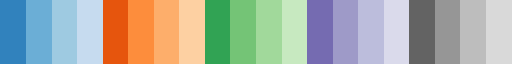

In [122]:
t20c

In [123]:
palette_appendix = {
    "OT-CP-Global": t20c(0),
    "OT-CP-Local": t20c(1),
    "Ell-Local": t20c(2),
    "PB": t20c(4),
    "RPB": t20c(5),
    "HPD": t20c(6),
    "Quantile": t20c(7),
    "PB (Y)": t20c(8),
    "RPB (Y)": t20c(9),
    "HPD (Y)": t20c(10),
    "Quantile (Y)": t20c(11),
    "PB (RF)": t20c(12),
    "RPB (RF)": t20c(13),
    "HPD (RF)": t20c(14),
    "Quantile (RF)": t20c(15),
    "PB (Y, RF)": t20c(16),
    "RPB (Y, RF)": t20c(17),
    "HPD (Y, RF)": t20c(18),
    "Quantile (Y, RF)": t20c(19),
}

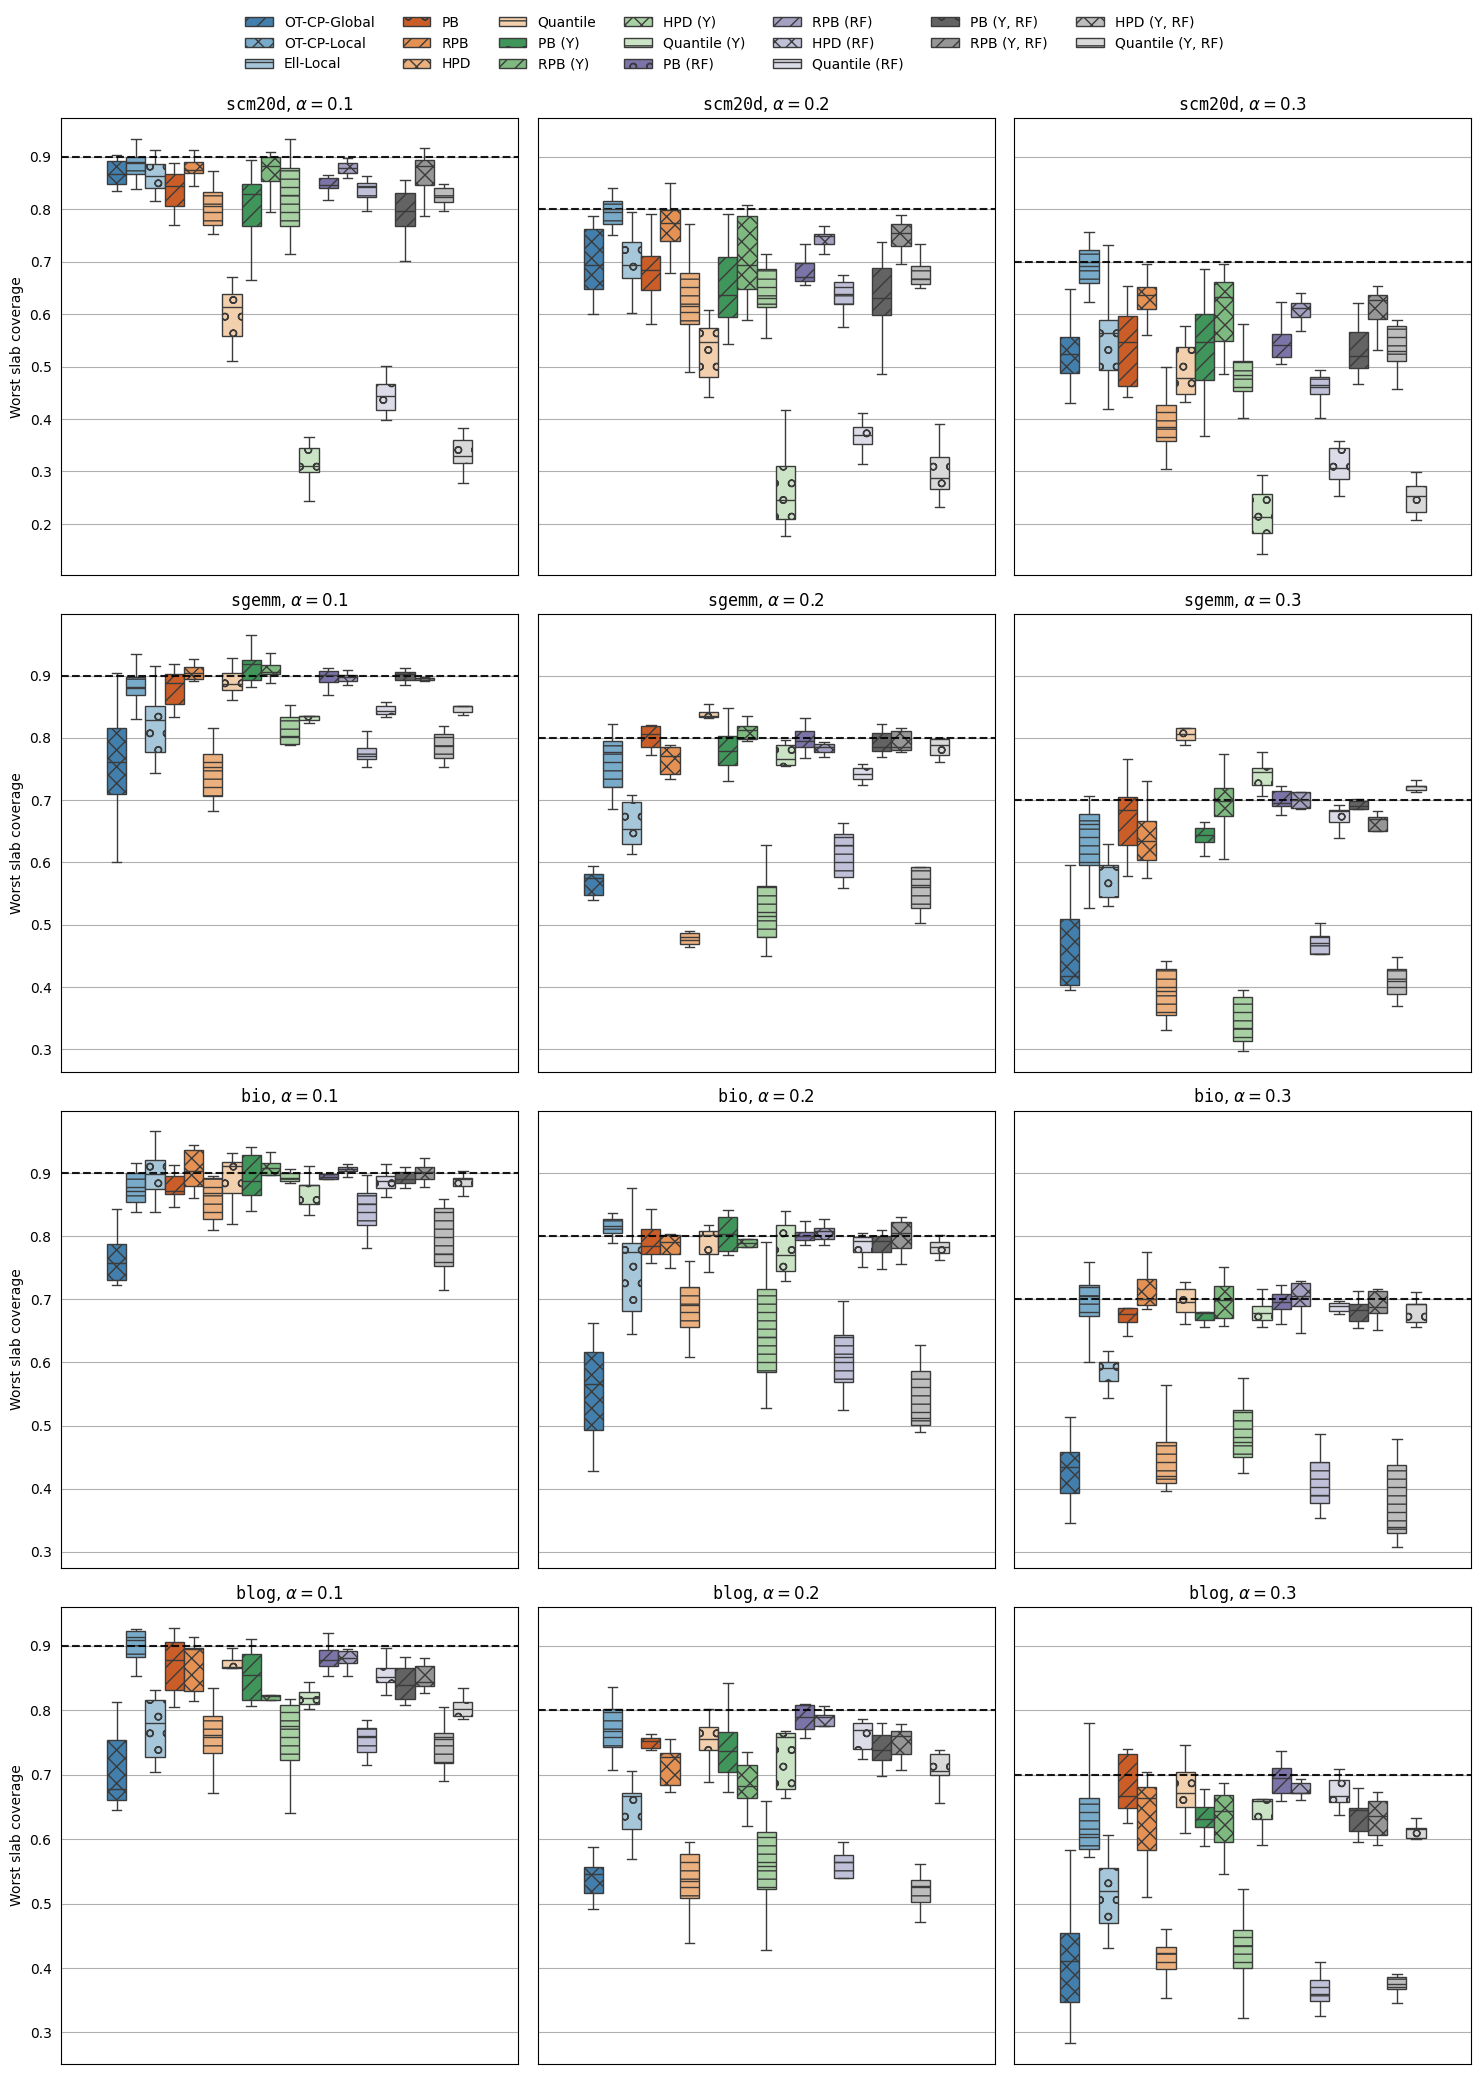

In [145]:
#n_facets_to_plot = new_ugly_filter_wsc_df["dataset_name"].nunique()
#print(n_facets_to_plot)
iclr_width = 5.50107
plot_aspect_wide = 16 / 9
plot_height = iclr_width / plot_aspect_wide
sns.set_style({'axes.grid' : True})
g_wsc = sns.catplot(
    data=df_main,
    kind="box",
    y="worst_slab_coverage",
    col="alpha",
    row="dataset_name",
    #col="dataset_name",
    hue="method_name", #_mathtext",
    palette=palette_appendix,
    sharey="row",
    showfliers=False,
    #height=plot_height,
)
g_wsc.set_axis_labels("", "Worst slab coverage")
g_wsc.set_xticklabels([])
g_wsc.despine(bottom=False, top=False, right=False)
for (dataset_name, alpha), ax in g_wsc.axes_dict.items():
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$, $\alpha={alpha:.1f}$")
    ax.axhline(1 - alpha, xmax=1, ls="--", c="k", alpha=0.9)
for ax in g_wsc.axes.flatten():
    ax.tick_params(left=False, bottom=False)
    for i, patch in enumerate(ax.patches):
        # Blue bars first, then green bars
        patch.set_hatch(boxplot_hatches[(i - 3) % 4])
for j, legend_patch in enumerate(g_wsc.legend.get_patches()):
    legend_patch.set_hatch(boxplot_hatches[j % 4])

sns.move_legend(g_wsc, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette) // 2, title=None,
                )
g_wsc.savefig(plots_dir / "results_worst_slab_coverage_250925_hatch.pdf", bbox_inches="tight")
g_wsc.savefig(plots_dir / "results_worst_slab_coverage_250925_hatch.png", bbox_inches="tight")

# Selected results for main part

In [33]:
df['dataset_name'].unique()

array(['rf1', 'rf2', 'scm1d', 'scm20d', 'sgemm', 'bio', 'blog'],
      dtype=object)

In [34]:
#df

In [35]:
#g_all.axes_dict
#df[df['dataset_name'] == 'sgemm']

In [36]:
new_ugly_filter_wsc_df = df[
    (df["alpha"] == 0.1) &
    (~df["method_name"].str.contains("Quantile")) &
    ~df["method_name"].str.contains("HPD") &
    ~df["method_name"].str.contains("CPFlow") &
    ~df["dataset_name"].str.contains("rf") &
    ~df["dataset_name"].str.contains("scm1d") &
    ~df["method_name"].str.contains("Y")
].copy()
new_ugly_filter_wsc_df.columns

Index(['dataset_name', 'seed', 'method_name', 'method_name_mathtext',
       'score_name', 'conformalizer', 'base_model_name', 'alpha',
       'marginal_coverage', 'worst_slab_coverage', 'worst_slab_coverage_se',
       'volume', 'n_targets', 'log_vol_d'],
      dtype='object')

In [37]:
new_ugly_filter_wsc_df['worst_slab_coverage_error'] = np.log((new_ugly_filter_wsc_df['worst_slab_coverage'] - (1 - new_ugly_filter_wsc_df['alpha'])).abs())

/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
labels_main_part_old = [r"$\mathtt{OT}$-$\mathtt{CP}$", r"$\mathtt{OT}$-$\mathtt{CP}$+", 
                        r"$\mathrm{ELL}$",
                        r"$\mathrm{PB}_{U}$", r"$\mathrm{RPB}_{U}$",
                        r"$\mathrm{PB}_{Y}$", r"$\mathrm{RPB}_{Y}$",
                        r"$\mathrm{PBS}_{U}$", r"$\mathrm{RPBS}_{U}$",
                        r"$\mathrm{PBS}_{Y}$", r"$\mathrm{RPBS}_{Y}$",]

In [39]:
labels_main_part = [r"$\mathtt{OT}$-$\mathtt{CP}$", r"$\mathtt{OT}$-$\mathtt{CP}$+", 
                        r"$\mathrm{ELL}$",
                        r"$\mathrm{PB}$", r"$\mathrm{RPB}$",
                        r"$\mathrm{PBS}$", r"$\mathrm{RPBS}$",]

4


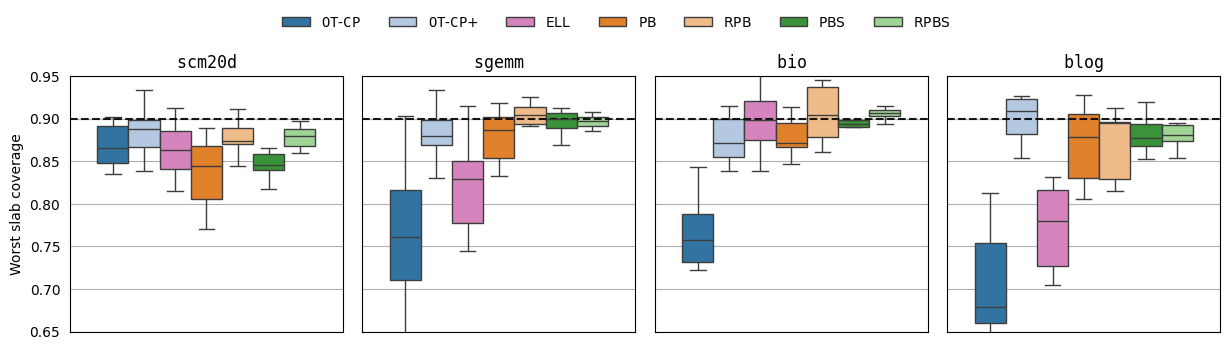

In [40]:
n_facets_to_plot = new_ugly_filter_wsc_df["dataset_name"].nunique()
print(n_facets_to_plot)
iclr_width = 5.50107
plot_aspect_wide = 16 / 9
plot_height = iclr_width / plot_aspect_wide
sns.set_style({'axes.grid' : True})
g_wsc = sns.catplot(
    data=new_ugly_filter_wsc_df,
    kind="box",
    y="worst_slab_coverage",
    #col="alpha",
    #row="dataset_name",
    col="dataset_name",
    hue="method_name", #_mathtext",
    palette=selected_palette,
    sharey=True,
    showfliers=False,
    height=plot_height,
)
sns.move_legend(g_wsc, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette), title=None,
                labels=labels_main_part)
g_wsc.set_axis_labels("", "Worst slab coverage")
g_wsc.set_xticklabels([])
g_wsc.despine(bottom=False, top=False, right=False)
#for (dataset_name, alpha,), ax in g_wsc.axes_dict.items():
for dataset_name, ax in g_wsc.axes_dict.items():
    #ax.set_title(rf"$\mathtt{{{dataset_name}}}$, $\alpha={alpha:.1f}$")
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$")
    ax.axhline(1 - 0.1, xmax=1, ls="--", c="k", alpha=0.9)
for ax in g_wsc.axes.flatten():
    ax.tick_params(left=False, bottom=False)
    ax.set_ylim(0.65, 0.95)

#g_wsc.savefig(plots_dir / "selected_results_worst_slab_coverage_250924.pdf", bbox_inches="tight")
#g_wsc.savefig(plots_dir / "selected_results_worst_slab_coverage_250924.png", bbox_inches="tight")

In [41]:
plot_height

3.0943518750000005

In [42]:
12 / 5 / 4

0.6

In [43]:
new_ugly_filter_volume_df = df[
    (df["alpha"] == 0.1) &
    (~df["method_name"].str.contains("Quantile")) &
    ~df["method_name"].str.contains("HPD") &
    ~df["method_name"].str.contains("CPFlow") &
    #~df["dataset_name"].str.contains("scm1d") &
    #~df["dataset_name"].str.contains("rf") &
    df["dataset_name"].isin(["scm20d", "sgemm", "bio", "blog"]) &
    ~df["method_name"].str.contains("Y")    
].copy()
new_ugly_filter_volume_df.columns

Index(['dataset_name', 'seed', 'method_name', 'method_name_mathtext',
       'score_name', 'conformalizer', 'base_model_name', 'alpha',
       'marginal_coverage', 'worst_slab_coverage', 'worst_slab_coverage_se',
       'volume', 'n_targets', 'log_vol_d'],
      dtype='object')

In [44]:
#new_ugly_filter_volume_df.query("dataset_name == 'sgemm' and method_name == 'OT-CP-Local'")["volume"]

In [45]:
#new_ugly_filter_volume_df.query("dataset_name == 'sgemm' and method_name == 'OT-CP-Global'")["volume"]

In [46]:
#new_ugly_filter_volume_df.query("dataset_name == 'sgemm' and method_name == 'PB'")["volume"]

In [54]:
df_four_volumes = pd.read_csv("four_volumes.csv").set_index(["dataset_name", "seed"])
df_four_volumes

Unnamed: 0      mean       std    median      q_25  \
dataset_name seed                                                       
scm20d       0              0 -0.546586  0.196573 -0.576811 -0.667664   
             1              1 -0.556434  0.192764 -0.573103 -0.680800   
             3              2 -0.515082  0.197105 -0.526326 -0.638684   
sgemm        0              3 -5.134538  2.620046 -4.053498 -4.230979   
             1              4 -5.354095  2.730885 -4.082458 -4.293005   
             3              5 -4.880703  2.417480 -3.977147 -4.127616   
bio          0              6 -0.322174  0.406173 -0.324365 -0.577220   
             1              7 -0.285809  0.431710 -0.307572 -0.578514   
             3              8 -0.329245  0.399798 -0.380345 -0.630814   
blog         0              9 -0.641398  0.710919 -0.795255 -1.164641   
             1             10 -0.721391  0.709146 -0.829615 -1.227302   
             3             11 -0.744481  0.675308 -0.867785 -1.199822   

                       q_75  
dataset_name seed            
scm20d       0    -0.444251  
             1    -0.453167  
             3    -0.405586  
sgemm        0    -3.877950  
             1    -3.902966  
             3    -3.800565  
bio          0    -0.085029  
             1    -0.072662  
             3    -0.089781  
blog         0    -0.249166  
             1    -0.349973  
             3    -0.390880

In [79]:
df_four_volumes_rf = pd.read_csv("four_volumes_rf.csv").set_index(["dataset_name", "seed"])
df_four_volumes_rf

Unnamed: 0      mean       std    median      q_25  \
dataset_name seed                                                       
scm20d       0              0 -0.431325  0.202293 -0.446131 -0.575089   
             1              1 -0.488145  0.259894 -0.501979 -0.676329   
             3              2 -0.461692  0.209360 -0.476508 -0.605545   
sgemm        0              3 -4.990112  2.334013 -4.365480 -4.835772   
             1              4 -4.744532  1.981230 -4.348059 -4.746442   
             3              5 -4.706454  1.925021 -4.370163 -4.778695   
bio          0              6 -0.314225  0.441339 -0.349237 -0.639484   
             1              7 -0.239793  0.418054 -0.304843 -0.537934   
             3              8 -0.203878  0.430895 -0.255753 -0.477975   
blog         0              9 -0.282874  0.678897 -0.430781 -0.816963   
             1             10 -0.284556  0.638152 -0.347964 -0.784455   
             3             11 -0.328614  0.671989 -0.443722 -0.848429   

                       q_75  
dataset_name seed            
scm20d       0    -0.302508  
             1    -0.335979  
             3    -0.334856  
sgemm        0    -3.923522  
             1    -3.876697  
             3    -3.888655  
bio          0    -0.054354  
             1    -0.023919  
             3    -0.016692  
blog         0     0.134116  
             1     0.144451  
             3     0.115835

In [86]:
import itertools


new_ugly_filter_volume_corrected_df = \
    new_ugly_filter_volume_df[(new_ugly_filter_volume_df["seed"].isin([0, 1, 3])) | (~new_ugly_filter_volume_df["method_name"].isin(["PB", "PB (RF)"]))].copy()
for dataset_name, seed in itertools.product(["scm20d", "sgemm", "bio", "blog"], [0, 1, 3]):
    #new_ugly_filter_volume_corrected_df["log_vol_d"] 
    new_ugly_filter_volume_corrected_df.loc[
        ((new_ugly_filter_volume_corrected_df["method_name"] == "PB")) & (new_ugly_filter_volume_corrected_df["dataset_name"] == dataset_name) & (new_ugly_filter_volume_corrected_df["seed"] == seed),
        "log_vol_d"
    ] = df_four_volumes.loc[(dataset_name, seed), "mean"]
    new_ugly_filter_volume_corrected_df.loc[
        ((new_ugly_filter_volume_corrected_df["method_name"] == "PB (RF)")) & (new_ugly_filter_volume_corrected_df["dataset_name"] == dataset_name) & (new_ugly_filter_volume_corrected_df["seed"] == seed),
        "log_vol_d"
    ] = df_four_volumes_rf.loc[(dataset_name, seed), "mean"]
new_ugly_filter_volume_corrected_df.query("method_name == 'PB (RF)'")[["dataset_name", "seed", "log_vol_d"]]

,dataset_name,seed,log_vol_d
2814,scm20d,0,-0.431325
2838,bio,0,-0.314225
2862,blog,0,-0.282874
2910,scm20d,1,-0.488145
2934,bio,1,-0.239793
2950,blog,1,-0.284556
3118,scm20d,3,-0.461692
3142,sgemm,3,-4.706454
3166,bio,3,-0.203878
3190,blog,3,-0.328614


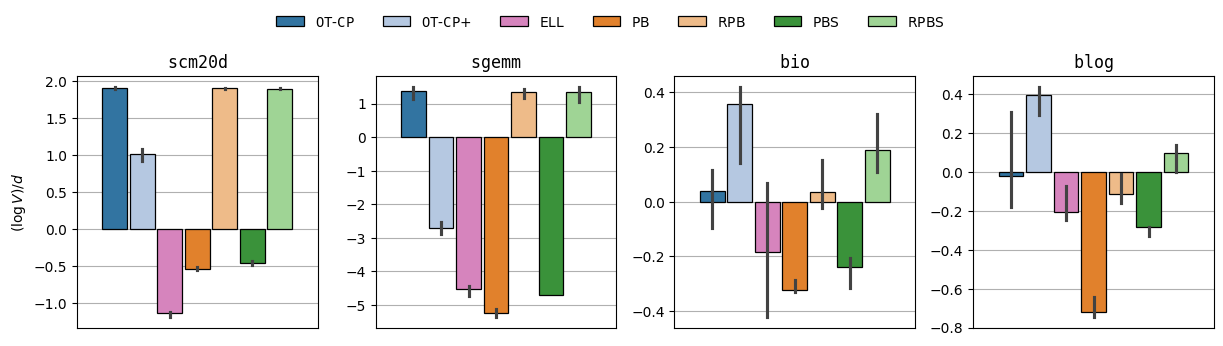

In [88]:
g_logvold = sns.catplot(
    data=new_ugly_filter_volume_corrected_df,#.query("dataset_name == 'bio' or dataset_name == 'blog'"),
    kind="bar",
    y="log_vol_d",
    #col="alpha",
    #row="dataset_name",
    col="dataset_name",
    hue="method_name", #_mathtext",
    estimator="median",
    palette=selected_palette,
    sharey=False,
    #showfliers=False,
    facet_kws={
        "despine": False,
    },
    height=plot_height,
    linewidth=0.9,
    edgecolor="k",
    dodge=2.6,
    gap=0.1,
)
sns.move_legend(g_logvold, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette), title=None, 
                labels=labels_main_part)
g_logvold.set_axis_labels("", r"$(\log V) / d$")#Worst slab coverage")
#g_logvold.set_axis_labels("", "Volume")
g_logvold.set_xticklabels([])
#g_logvold.despine(bottom=True)
for dataset_name, ax in g_logvold.axes_dict.items():
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$")
for ax in g_logvold.axes.flatten():
    ax.tick_params(bottom=False)
    ax.grid(visible=True, which="both", axis="y")
    ax.set_axisbelow(True)
    #ax.set_ylim(None, 2.5)

g_logvold.savefig(plots_dir / "selected_results_volume_250925.pdf", bbox_inches="tight")
g_logvold.savefig(plots_dir / "selected_results_volume_250925.png", bbox_inches="tight")

In [48]:
np.log(6427081) / 16

np.float64(0.9797519392096724)

In [45]:
new_ugly_filter_volume_df.query("method_name == 'Ell-Local'").volume.min()

np.float64(4.656267465439428e-09)

In [46]:
os.getcwd()

'/home/alex/repos/conditional_quantile_function'

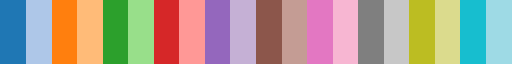

In [47]:
colormap = matplotlib.colormaps["tab20"]
colormap

In [48]:
tuned_params = {}
dfs = []
for dataset_name in ("rf1", "rf2", "scm1d", "scm20d"):
    df_tuning = pd.read_feather(f"./conformal_results_slurm/{dataset_name}/53/tuning.feather")
    print(df_tuning.loc[df_tuning['error'].idxmin()])
    tuned_params[dataset_name] = df_tuning.loc[df_tuning['error'].idxmin()].to_dict()
    df_tuning["dataset_name"] = dataset_name
    dfs.append(df_tuning)
df_tuning = pd.concat(dfs)

error                                                               0.042556
errors                     [0.009999999999999995, 0.0, 0.0015000000000000...
learning_rate                                                          0.001
batch_size                                                               512
n_epochs                                                                 150
warmup_iterations                                                         50
feature_dimension                                                         50
response_dimension                                                         8
hidden_dimension                                                          10
number_of_hidden_layers                                                    1
Name: 51, dtype: object
error                                                                  0.037
errors                     [0.0155, 0.003999999999999976, 5.5511151231257...
learning_rate                                       

In [49]:
print(tuned_params)

{'rf1': {'error': 0.042555555555555576, 'errors': array([0.01  , 0.    , 0.0015, 0.0025, 0.027 , 0.0525, 0.076 , 0.0945,
       0.119 ]), 'learning_rate': 0.001, 'batch_size': 512, 'n_epochs': 150, 'warmup_iterations': 50, 'feature_dimension': 50, 'response_dimension': 8, 'hidden_dimension': 10, 'number_of_hidden_layers': 1}, 'rf2': {'error': 0.037000000000000005, 'errors': array([1.55000000e-02, 4.00000000e-03, 5.55111512e-17, 1.05000000e-02,
       2.00000000e-02, 3.55000000e-02, 6.10000000e-02, 8.25000000e-02,
       1.04000000e-01]), 'learning_rate': 0.001, 'batch_size': 2048, 'n_epochs': 150, 'warmup_iterations': 50, 'feature_dimension': 100, 'response_dimension': 8, 'hidden_dimension': 8, 'number_of_hidden_layers': 2}, 'scm1d': {'error': 0.08255555555555555, 'errors': array([0.1055, 0.0995, 0.0745, 0.046 , 0.006 , 0.0355, 0.0755, 0.1305,
       0.17  ]), 'learning_rate': 0.01, 'batch_size': 2048, 'n_epochs': 150, 'warmup_iterations': 50, 'feature_dimension': 100, 'response_dimens

<Axes: xlabel='n_epochs', ylabel='error'>

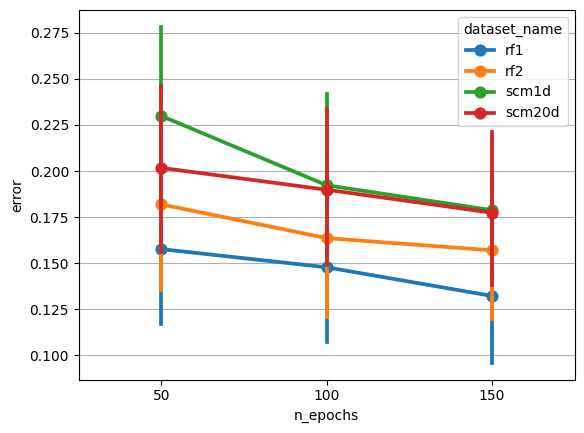

In [50]:
sns.pointplot(df_tuning, x="n_epochs", y="error", hue="dataset_name")

In [51]:
df3 = load_methods_from(method_names=[], path="./conformal_results_sgemm_no_areas/", seeds=range(10, 15), extention="feather")
df4 = load_methods_from(method_names=[], path="./conformal_results_sgemm_areas/", seeds=range(10, 15),extention="feather")

Error: dataset rf1, seed 10 not found.
Error: dataset rf2, seed 10 not found.
Error: dataset scm1d, seed 10 not found.
Error: dataset scm20d, seed 10 not found.
Error: dataset bio, seed 10 not found.
Error: dataset blog, seed 10 not found.
Error: dataset rf1, seed 11 not found.
Error: dataset rf2, seed 11 not found.
Error: dataset scm1d, seed 11 not found.
Error: dataset scm20d, seed 11 not found.
Error: dataset bio, seed 11 not found.
Error: dataset blog, seed 11 not found.
Error: dataset rf1, seed 12 not found.
Error: dataset rf2, seed 12 not found.
Error: dataset scm1d, seed 12 not found.
Error: dataset scm20d, seed 12 not found.
Error: dataset bio, seed 12 not found.
Error: dataset blog, seed 12 not found.
Error: dataset rf1, seed 13 not found.
Error: dataset rf2, seed 13 not found.
Error: dataset scm1d, seed 13 not found.
Error: dataset scm20d, seed 13 not found.
Error: dataset bio, seed 13 not found.
Error: dataset blog, seed 13 not found.
Error: dataset rf1, seed 14 not found.
E

/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
df_sgemm = pd.merge(df3, df4,)

In [53]:
df_sgemm

,dataset_name,seed,method_name,method_name_mathtext,score_name,conformalizer,base_model_name,alpha,marginal_coverage,worst_slab_coverage,worst_slab_coverage_se,n_targets,volume,log_vol_d
0,sgemm,10,PB (RF),$\mathcal{C}^{\mathrm{pb}} \: RF$,MK Rank,SplitConformalPredictor,CVQRegressorRF,0.1,0.9135,0.781676,0.013136,4,0.000343,-1.994584
1,sgemm,10,RPB (RF),$\mathcal{C}^{\mathrm{rpb}} \: RF$,MK Quantile,OTCPGlobalPredictor,CVQRegressorRF,0.1,0.9155,0.844753,0.020906,4,214.320355,1.341868
2,sgemm,10,HPD (RF),$\mathcal{C}^{\mathrm{HPD}} \: RF$,Log Density,SplitConformalPredictor,CVQRegressorRF,0.1,0.9065,0.735407,0.010491,4,0.000686,-1.821298
3,sgemm,10,Quantile (RF),$Q_{Y|X} \: RF$,MK Rank,QuantileEstimatePredictor,CVQRegressorRF,0.1,0.9570,0.883130,0.013343,4,0.004114,-1.373358
4,sgemm,10,"PB (Y, RF)",$\mathcal{C}^{\mathrm{pb}} \: Y \: RF$,MK Rank,SplitConformalPredictor,CVQRegressorYRF,0.1,0.9150,0.901236,0.007392,4,0.000343,-1.994584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,sgemm,14,Quantile (RF),$Q_{Y|X} \: RF$,MK Rank,QuantileEstimatePredictor,CVQRegressorRF,0.3,0.9115,0.899409,0.009855,4,0.000000,-inf
92,sgemm,14,"PB (Y, RF)",$\mathcal{C}^{\mathrm{pb}} \: Y \: RF$,MK Rank,SplitConformalPredictor,CVQRegressorYRF,0.3,0.7140,0.695022,0.011922,4,0.000000,-inf
93,sgemm,14,"RPB (Y, RF)",$\mathcal{C}^{\mathrm{rpb}} \: Y \: RF$,MK Quantile,OTCPGlobalPredictor,CVQRegressorYRF,0.3,0.7105,0.702446,0.015177,4,0.000000,-inf
94,sgemm,14,"HPD (Y, RF)",$\mathcal{C}^{\mathrm{HPD}} \: Y \: RF$,Log Density,SplitConformalPredictor,CVQRegressorYRF,0.3,0.7120,0.315832,0.021631,4,0.000000,-inf


(0.0, 2.5)

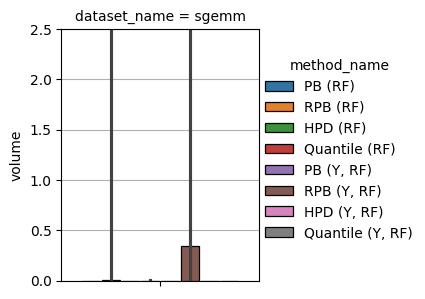

In [54]:
g_sgemm_vold = sns.catplot(
    data=df_sgemm,
    kind="bar",
    y="volume",
    #col="alpha",
    #row="dataset_name",
    col="dataset_name",
    hue="method_name", #_mathtext",
    estimator="median",
    #palette=selected_palette,
    sharey=True,
    #showfliers=False,
    facet_kws={
        "despine": False,
    },
    height=plot_height,
    linewidth=0.9,
    edgecolor="k",
    dodge=2.6,
    gap=0.1,
)
plt.ylim(0, 2.5)

In [55]:
df_sgemm.plot("volume", kind="hist")

ValueError: autodetected range of [-inf, 14.0] is not finite

In [ ]:
(df_sgemm["volume"] > 0).sum()

np.int64(25)